In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error  # or accuracy_score, etc.
import lightgbm as lgb

from src.data import DataLoader
from src.evaluate import evaluate
from src.preprocessing import PreProcessClass

In [3]:
# sys.path.append(str(Path("Alpiq ETHdatathon challenge 2025").resolve()))
input_path = "datasets2025/"
loader = DataLoader(input_path)

**Italy preprocessing**

In [4]:
consumptions, features, example_solution = loader.load_data("IT")
preprocessor_it = PreProcessClass(x=consumptions, features=features)

col_customersIT = [
    id
    for id in consumptions.columns
    if id.startswith("VALUEMWHMETERINGDATA_customerIT")
]
dataIT = preprocessor_it.preprocess_nonan(col_customersIT)

**Spain preprocessing**

In [5]:
consumptions, features, example_solution = loader.load_data("ES")
preprocessor_es = PreProcessClass(consumptions, features)

# Pick all customer columns
col_customersES = [
    id
    for id in consumptions.columns
    if id.startswith("VALUEMWHMETERINGDATA_customerES")
]
dataES = preprocessor_es.preprocess_nonan(col_customersES)

In [6]:
id_columns = [
    "DateTime",
    "Hour",
    "Month",
    "Day",
    "Year",
    "Dow",
    "IsWeekend",
    "temp",
    "spv",
]

dataIT["DateTime"] = dataIT.index
dfIT = dataIT.reset_index().melt(
    id_vars=id_columns,
    value_vars=col_customersIT,
    var_name="Customer",
    value_name="Consumption",
)

dataES["DateTime"] = dataES.index
dfES = dataES.reset_index().melt(
    id_vars=id_columns,
    value_vars=col_customersES,
    var_name="Customer",
    value_name="Consumption",
)

dfIT["Customer"] = dfIT["Customer"].str.replace("VALUEMWHMETERINGDATA_customer", "")
dfES["Customer"] = dfES["Customer"].str.replace("VALUEMWHMETERINGDATA_customer", "")

dfIT.set_index("DateTime", inplace=True)
dfES.set_index("DateTime", inplace=True)
dfIT.head()

,Hour,Month,Day,Year,Dow,IsWeekend,temp,spv,Customer,Consumption
DateTime,,,,,,,,,,
2022-01-01 00:00:00,0,1,1,2022,5,1,3.9,0.0,IT_1,0.001547
2022-01-01 01:00:00,1,1,1,2022,5,1,3.7,0.0,IT_1,0.001617
2022-01-01 02:00:00,2,1,1,2022,5,1,3.4,0.0,IT_1,0.001490
2022-01-01 03:00:00,3,1,1,2022,5,1,3.4,0.0,IT_1,0.000798
2022-01-01 04:00:00,4,1,1,2022,5,1,3.6,0.0,IT_1,0.000592


In [7]:
df_all = pd.concat([dfIT, dfES]).sort_index()

X = df_all.drop(columns=["Consumption"])
y = df_all[["Customer", "Consumption"]]
X.head()

,Hour,Month,Day,Year,Dow,IsWeekend,temp,spv,Customer
DateTime,,,,,,,,,
2022-01-01,0,1,1,2022,5,1,3.9,0.0,IT_1
2022-01-01,0,1,1,2022,5,1,3.9,0.0,IT_123
2022-01-01,0,1,1,2022,5,1,3.9,0.0,IT_2001
2022-01-01,0,1,1,2022,5,1,3.9,0.0,IT_1998
2022-01-01,0,1,1,2022,5,1,3.9,0.0,IT_1995


In [8]:
# Date on which we want to split the data
date = pd.to_datetime("2024-07-01 00:00:00")

y = y.drop(columns=["Customer"])
X_train = X[X.index < date]
X_test = X[X.index >= date]
y_train = y[y.index < date]
y_test = y[y.index >= date]

In [9]:
categorical_features = ["Customer"]
bool_features = ["IsWeekend"]

for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

for col in bool_features:
    X_train[col] = X_train[col].astype("bool")
    X_test[col] = X_test[col].astype("bool")

/var/folders/gt/bf8tgbk957x99qyxtn12vh7r0000gn/T/ipykernel_88118/2225099780.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype("category")
/var/folders/gt/bf8tgbk957x99qyxtn12vh7r0000gn/T/ipykernel_88118/2225099780.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype("category")
/var/folders/gt/bf8tgbk957x99qyxtn12vh7r0000gn/T/ipykernel_88118/2225099780.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [10]:
col_to_remove = ["IsWeekend", "spv", "temp", "Day"]

X_train = X_train.drop(columns=col_to_remove)
X_test = X_test.drop(columns=col_to_remove)

categorical_features_left = list(set(categorical_features) - set(col_to_remove))

In [11]:
train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical_features_left
)
val_data = lgb.Dataset(
    X_test,
    label=y_test,
    categorical_feature=categorical_features_left,
    reference=train_data,
)

In [12]:
params = {
    "objective": "regression",  # or 'binary'/'multiclass' depending on your task
    "metric": "mae",  # or 'binary_logloss', 'multi_logloss', etc.
    "boosting_type": "gbdt",
    "verbosity": -1,
    "learning_rate": 0.05,
    "num_leaves": 2000,
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000,
    callbacks=[lgb.log_evaluation(period=10)],
)

[10]	training's l1: 0.119179	valid_1's l1: 0.118774
[20]	training's l1: 0.0809985	valid_1's l1: 0.0827531
[30]	training's l1: 0.0591458	valid_1's l1: 0.0625986
[40]	training's l1: 0.0466799	valid_1's l1: 0.0511736
[50]	training's l1: 0.0395128	valid_1's l1: 0.0446066
[60]	training's l1: 0.0353126	valid_1's l1: 0.0406468
[70]	training's l1: 0.0327201	valid_1's l1: 0.0380375
[80]	training's l1: 0.031036	valid_1's l1: 0.0362503
[90]	training's l1: 0.0298202	valid_1's l1: 0.0349077
[100]	training's l1: 0.028934	valid_1's l1: 0.0339502
[110]	training's l1: 0.0282865	valid_1's l1: 0.0332237
[120]	training's l1: 0.0277227	valid_1's l1: 0.0326007
[130]	training's l1: 0.0272848	valid_1's l1: 0.0321318
[140]	training's l1: 0.0268978	valid_1's l1: 0.0316634
[150]	training's l1: 0.0265457	valid_1's l1: 0.0312887
[160]	training's l1: 0.0262829	valid_1's l1: 0.030947
[170]	training's l1: 0.0260606	valid_1's l1: 0.0306772
[180]	training's l1: 0.0258839	valid_1's l1: 0.0304579
[190]	training's l1: 0.0

In [13]:
## Uncomment the following lines to save the model

# import pickle

# Assume your model is stored in a variable named 'model'
# with open('model.pkl', 'wb') as f:
# pickle.dump(model, f)

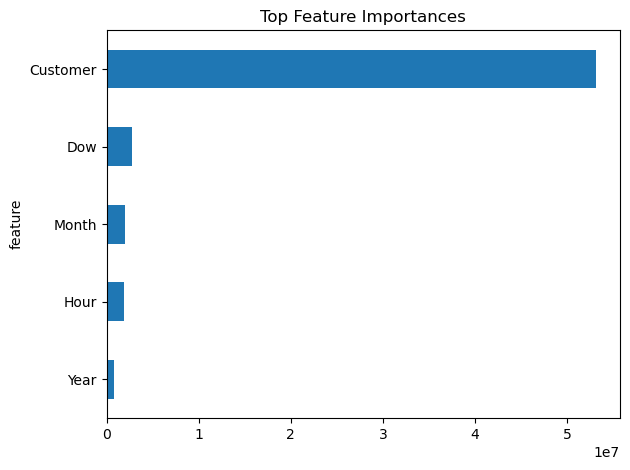

In [ ]:
importance = model.feature_importance(importance_type="gain")
features = model.feature_name()

feat_df = pd.DataFrame({"feature": features, "importance": importance}).sort_values(
    by="importance", ascending=False
)

feat_df.head(10).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [15]:
y_test_modified = y_test.fillna(0).to_numpy()
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = mean_squared_error(y_test_modified, y_pred)
print(f"RMSE: {rmse}")

RMSE: 0.018382848532746347


In [18]:
true = df_all[["Customer", "Consumption"]].copy()
true = true[true.index >= date]
pivoted_true = true.pivot(columns="Customer", values="Consumption")

it_df_true = pivoted_true.filter(like="IT_", axis=1)
es_df_true = pivoted_true.filter(like="ES_", axis=1)

pivoted_true.head()

Customer,ES_1,ES_100,ES_104,ES_107,ES_109,ES_11,ES_114,ES_115,ES_117,ES_126,...,IT_982,IT_984,IT_985,IT_987,IT_988,IT_991,IT_992,IT_995,IT_996,IT_998
DateTime,,,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,0.001040,0.030804,0.022380,0.013556,0.054,0.015900,3.962,0.221,0.023,0.002100,...,0.000024,0.001250,0.001850,0.000076,0.005225,0.000896,0.002075,0.003724,0.000514,0.001150
2024-07-01 01:00:00,0.000940,0.028396,0.022268,0.011736,0.057,0.015936,4.231,0.238,0.026,0.002472,...,0.000024,0.001458,0.001975,0.000076,0.005075,0.000896,0.002075,0.003750,0.000510,0.001175
2024-07-01 02:00:00,0.000948,0.027264,0.021696,0.011896,0.054,0.016892,4.306,0.228,0.026,0.001580,...,0.000024,0.001382,0.001825,0.000076,0.005250,0.000896,0.002125,0.003750,0.000513,0.001175
2024-07-01 03:00:00,0.001084,0.027984,0.022368,0.016124,0.054,0.015104,4.122,0.219,0.022,0.002496,...,0.000024,0.001058,0.001875,0.000076,0.005125,0.000896,0.002300,0.003700,0.000485,0.001175
2024-07-01 04:00:00,0.000832,0.031076,0.021436,0.014236,0.053,0.035684,4.206,0.211,0.042,0.003068,...,0.000024,0.001352,0.001950,0.000076,0.005250,0.000896,0.002550,0.003775,0.000536,0.001150


In [19]:
pred = pd.DataFrame(y_pred, index=true.index, columns=["Consumption"])
pred["name"] = X_test["Customer"]
pivoted_pred = pred.pivot(columns="name", values="Consumption")

it_df_pred = pivoted_pred.filter(like="IT_", axis=1)
es_df_pred = pivoted_pred.filter(like="ES_", axis=1)

pivoted_pred.head()

name,ES_1,ES_100,ES_104,ES_107,ES_109,ES_11,ES_114,ES_115,ES_117,ES_126,...,IT_982,IT_984,IT_985,IT_987,IT_988,IT_991,IT_992,IT_995,IT_996,IT_998
DateTime,,,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,0.001538,0.023956,0.028667,0.011234,0.048063,0.011994,3.427561,0.228123,0.090245,0.002108,...,0.000367,0.000267,0.010514,0.000289,0.010731,0.001480,0.001360,0.005854,0.000594,0.002451
2024-07-01 01:00:00,0.001382,0.026064,0.028060,0.011049,0.047272,0.011674,3.500473,0.227148,0.090972,0.001964,...,0.000178,0.000065,0.010634,0.000119,0.010719,0.001318,0.001204,0.005643,0.000419,0.002275
2024-07-01 02:00:00,0.001288,0.025762,0.027826,0.010943,0.045376,0.012744,3.550892,0.227350,0.090735,0.001849,...,0.000050,-0.000048,0.010518,0.000010,0.010838,0.001210,0.001101,0.005541,0.000321,0.002146
2024-07-01 03:00:00,0.001644,0.025867,0.028069,0.011297,0.045968,0.013726,3.543045,0.226183,0.092057,0.002193,...,0.000405,0.000307,0.015201,0.000363,0.011165,0.001560,0.001453,0.006035,0.000669,0.002498
2024-07-01 04:00:00,0.001865,0.026307,0.027489,0.011582,0.045293,0.014270,3.559673,0.224092,0.097024,0.002470,...,0.000655,0.000557,0.019143,0.000627,0.011323,0.001807,0.001722,0.006423,0.000928,0.002801


In [20]:
mask_it = X_test["Customer"].apply(lambda x: x.startswith("IT_"))
mask_es = X_test["Customer"].apply(lambda x: x.startswith("ES_"))

pred_it = y_pred[mask_it]
pred_es = y_pred[mask_es]
true_it = y_test[mask_it]
true_es = y_test[mask_es]

In [21]:
evaluate(pred_it=it_df_pred, true_it=it_df_true, pred_es=es_df_pred, true_es=es_df_true)


                 FORECAST EVALUATION REPORT                 

IT PERFORMANCE
------------------------------------------------------------

Metric                  Score  Weight  Weighted Score
Absolute Error   63394.987653     1.0    63394.987653
Portfolio Error   8986.915178    10.0    89869.151783

Top 3 consumers with highest error in Italy:

name
IT_506     2026.11
IT_1689    1530.87
IT_505     1311.67

ES PERFORMANCE
------------------------------------------------------------

Metric                  Score  Weight  Weighted Score
Absolute Error   10407.548324     5.0    52037.741618
Portfolio Error   2551.919571    50.0   127595.978534

Top 3 consumers with highest error in Spain:

name
ES_72     1590.99
ES_70     1531.54
ES_114     695.50

------------------------------------------------------------
                    TOTAL FORECAST SCORE                    
                           332898                           
-----------------------------------------------------------